In [0]:
from google.colab import drive
import os
drive.mount('/content/gdrive')#, force_remount=True)
curDir =('/content/gdrive/My Drive/Colab Notebooks/DeepMovement_project')
os.chdir(curDir)
!cat /content/gdrive/My\ Drive/Colab\ Notebooks/DeepMovement_project

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
cat: '/content/gdrive/My Drive/Colab Notebooks/DeepMovement_project': Is a directory


In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Imports

In [0]:
# In[1] Imports

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time
import pickle
from random import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.utils.np_utils import to_categorical
from keras.models import Model, load_model, model_from_json
from keras.layers import Dense, Input, Dropout, LSTM, Activation#, SpatialDropout1D
from keras.optimizers import SGD, Adam
# from google.colab import files
# src = list(files.upload().values())[0]
# open('UsedFunctions.py','wb').write(src)
from UsedFunctions import modelBuild
%load_ext autoreload
%autoreload 2

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

Using TensorFlow backend.


# Restore Model

In [0]:
temppath=os.path.join(curDir,'ModelData', 'Activity_P1_Tuning')
with open(os.path.join(temppath,'model_architecture.json'), 'r') as f:
    model = model_from_json(f.read())
print(model.summary()) # optional
filename = os.path.join(temppath, 'LSTM_model_variables.sav')
with open(filename, 'rb') as handle:
    classes = pickle.load(handle)
#     learning_rate = pickle.load(handle)
#     batch_length = pickle.load(handle)
#     lr_decay = pickle.load(handle)
    layer_size = pickle.load(handle)
    dense_size = pickle.load(handle)
    results_ret = pickle.load(handle)

print('classes: ', classes)
# print('learning_rate: ', learning_rate)
# print('lr_decay: ', lr_decay)
print('layer_sizes:', layer_size)
print('dense_size: ', dense_size)
print('results: ')
print(*results_ret, sep='\n')


# Definitions Functions

In [0]:
# In[2] Methods
def ReadData():
    """ ----- Very important to note the pathes ----- """
    # Getting training data
    df = pd.read_csv(os.path.join('.','Output','Activity_train.csv')) #read data
    df.dropna(axis=0, how='any', thresh=76, subset=None, inplace=True)
    # Getting consistant sequence of frames
    fr = df.copy()['Frame']
    target = df.copy()['Human']
    
    #dropping usless columns and columns with all their values are 0
    dropped = ['Human', 'V_title', 'Frame', 'L Foot_x_PCM', 'L Foot_y_PCM', 'R Foot_L',	'L Foot_L',	'Head & Neck_R',	'Trunk_R',	'R Upper Arm_R',	'L Upper Arm_R',	'R Forearm_R',	'L Forearm_R',	'R Hand_R',	'L Hand_R',	'R Thigh_R',	'L Thigh_R',	'R Shank_R',	'L Shank_R',	'R Foot_R',	'L Foot_R']
    df.drop(columns=dropped, inplace=True)
    
    seq_count = np.zeros(fr.shape, dtype=int)
    for i in range(1, len(fr.index)):
        # assuming if there is > 30 frames gap, the scene is changed
        if np.abs(fr.values[i-1] - fr.values[i]) > 30:
            seq_count[i] = seq_count[i-1] + 1
        else:
            seq_count[i] = seq_count[i-1]
    framesInSeq = np.bincount(seq_count)
    maxSeq = framesInSeq.max() + 1 #// 13
        
    nan_locations = np.isnan(np.float_(df.values)) # get locations of nan values to set to 0 later
    df.fillna(0, inplace=True) # convert NaN values to zeros
    
    array = df.values #conver df to array
    X = np.array(array, dtype='float')
    #target = array[:, 0] #split target data
    l = list(set(target.copy()))
    labelencoder = LabelEncoder()
    target = labelencoder.fit_transform(target)
    
    # get unique labels 
    unique_labels = dict(zip(labelencoder.fit_transform(l), l))
    
    #X = np.delete(X, np.s_[:1], 1) #drop target data 
    #X = np.float64(X)
    Y = np.array(target, dtype='int')
    #Y=Y.astype('int') # issue
    
    # Feature scaling 
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    X[nan_locations]=0 # set location of nans to 0
    
    Data_X = []
    Data_Y = []
    Num = 0
    ind = 0
    for cLen in framesInSeq:
        #if clen > maxSeq:
        #    clen /= 3
        for i in range(1 + (cLen // maxSeq)):
            if cLen < 4:
                break
            x = []
            for j in range(maxSeq):
                if (maxSeq*i + j) >= cLen:
                    x = np.tile(x, (maxSeq//len(x)+1, 1))[:maxSeq].tolist()
                    break
                else:
                    x.append(list(X[Num + maxSeq*i + j]))
                    y = Y[Num + maxSeq*i + j]
            Data_X.append(x)
            Data_Y.append(y) 
        Num += cLen
        ind += 1
    Data_Y = to_categorical(Data_Y) # convert to one hot
    return np.array(Data_X, dtype='float32'), np.array(Data_Y, dtype='float32'), unique_labels, maxSeq

def modelBuild2(input_shape, lstm_out, dense_out):
    NumLyrs = len(lstm_out)
    NumDns = len(dense_out)
    sentence_indices = Input(input_shape)
    # The returned output should be a batch of sequences.
    if NumLyrs > 1:
        X = LSTM(lstm_out[0], return_sequences=True, dropout=0.25, recurrent_dropout=0.35)(sentence_indices)
        if NumLyrs>2:
            # Propagate X trough another LSTM layer with lstm_out-dimensional hidden state
            X = LSTM(lstm_out[1], return_sequences=True, dropout=0.25, recurrent_dropout=0.35)(X)
            if NumLyrs>3:
                # Propagate X trough another LSTM layer with lstm_out-dimensional hidden state
                X = LSTM(lstm_out[2], return_sequences=True, dropout=0.4, recurrent_dropout=0.5)(X)
    else:
        X = sentence_indices
    X = LSTM(lstm_out[-1], return_sequences=False, dropout=0.35, recurrent_dropout=0.35)(X)
    # Propagate X through a Dense layer with softmax activation.
    if NumDns>1:
        X = Dense(dense_out[0], activation='relu')(X)
        X = Dropout(0.7)(X)
        if NumDns>2:
            X = Dense(dense_out[1], activation='relu')(X)
            X = Dropout(0.4)(X)
    X = Dense(dense_out[-1])(X) # Number of classes
    # Add a softmax activation
    X = Activation('softmax')(X)
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    return model


# Operations

##  Data read

In [0]:
# In[4] Data manipulation

#reading data 
Trainpath = os.path.join(curDir, 'TrainData')
Data_X, Data_Y, classes, sequence_size = ReadData()
# shuffling data
Z= list(zip(Data_X[:,:-21], Data_Y))
shuffle(Z)
Data_X, Data_Y = zip(*Z)
Data_X, Data_Y = np.array(Data_X), np.array(Data_Y)
X_train, X_test, y_train, y_test = train_test_split(Data_X, Data_Y, test_size=0.20, random_state=42)


In [0]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(classes)

(971, 50, 79) (971, 3)
(243, 50, 79) (243, 3)
{1: 'running', 0: 'jogging', 2: 'walking'}


## Tunning

####################################################################
At lstm layer sizes = [128, 64, 32]
####################################################################
At dense layer = [128]


W0701 17:29:43.614852 140469782656896 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50, 79)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50, 128)           106496    
_________________________________________________________________
lstm_5 (LSTM)                (None, 50, 64)            49408     
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               4224      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
__________

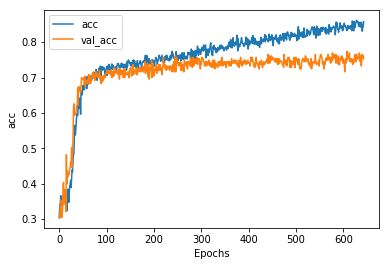

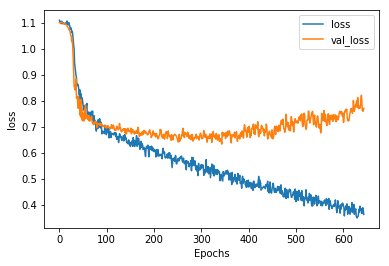

Loss is  0.7364942308806588
Acc is  0.7736625619876532
Found Better Model.......
best acc: 0.773663
best loss: 0.736494
Final_layers: [128, 64, 32]
Final_dense_layer: [128, 3]
{'loss': 0.7364942308806588, 'acc': 0.7736625619876532, 'lstm_out': [128, 64, 32], 'dense_layer': [128, 3]}


In [0]:
# In[3] Begining of Training
beg = time.time()
# Variables
# sequence_size = 3
epochs = 1000
# lstm_out = [112, 112]
# dense_layer = 32
batch_size = 128
acc_old = 0
loss_old = 1000
results = []
for lstm_out in [[128,64,32]]:
    for dense_layer in [[128]]:
        print('####################################################################')
        print('At lstm layer sizes = %s' %lstm_out)
        print('####################################################################')
        print('At dense layer = %s' %dense_layer)
        dense_layer.append(len(classes))
        # In[5] Training
        with tf.device('/gpu:0'):
            # Building the model
            model = modelBuild2(X_train.shape[1:], lstm_out, dense_layer)
            print(model.summary())
            opt = Adam(lr=5e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-7, amsgrad=False)
            model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

            # Saving weights of the model after every epoch in a given directory
            modelspath=os.path.join(curDir,'ModelData')
            if not os.path.exists(modelspath):
                os.makedirs(modelspath)
            # Preparing callbacks during training
            temppath=os.path.join(curDir,'ModelData', 'Activity_P1_Tuning')
            if not os.path.exists(temppath):
                os.makedirs(temppath)
            filepath=os.path.join(temppath,'weights-{epoch:02d}-{val_acc:.2f}.hdf5') ##@
            earlystop = EarlyStopping(monitor='val_loss', patience=300, verbose=1, restore_best_weights=True)
            checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_weights_only=True, save_best_only=True)
            # using tensorbard to visualize the training and view learning curves
            # to know when to stop and choose which epoch as the best, while the code is running 
            # run the following command in your terminal while pointing to the script directory
            tbCallBack = TensorBoard(log_dir='log', histogram_freq=0, write_graph=False, write_images=True)
            #model.load_weights(os.path.join(temppath, 'weights-497-0.78.hdf5'))
            # training the model and using validation data to validate the parameters (overfitting and so on..)
            history = model.fit(X_train, y_train, validation_data=(X_test,y_test),
                                epochs = epochs, batch_size = batch_size, shuffle=True,
                                verbose = 2, callbacks=[checkpoint,tbCallBack,earlystop])
            plot_graphs(history, 'acc')
            plot_graphs(history, 'loss')
            #loss, acc = model.evaluate(X_test, y_test)
            acc = max(history.history['val_acc'])
            loss = history.history['val_loss'][np.argmax(history.history['val_acc'])]
            print('Loss is ', loss)
            print('Acc is ', acc)
        results.append({'loss':loss, 'acc':acc, 'lstm_out':lstm_out, 'dense_layer':dense_layer})
        if loss < loss_old:
            print('Found Better Model.......')
            acc_old = acc
            loss_old = loss
            Final_model = model
            #Final_batch_size = batch_size
            #Final_learning_rate = lr
            #Final_portion = por
            #Final_lr_decay = decay
            Final_layers = lstm_out
            Final_dense_layer = dense_layer
                
                
                

        # Saving some variables that might be used during testing
        filename = os.path.join(temppath, 'LSTM_model_variables.sav')
        with open(filename, 'wb') as handle:
            pickle.dump(classes, handle, protocol=pickle.HIGHEST_PROTOCOL)
            #pickle.dump(Final_portion, handle, protocol=pickle.HIGHEST_PROTOCOL)
#             pickle.dump(5e-4, handle, protocol=pickle.HIGHEST_PROTOCOL)
#             pickle.dump(16, handle, protocol=pickle.HIGHEST_PROTOCOL)
#             pickle.dump(1e-7, handle, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(Final_layers, handle, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(Final_dense_layer, handle, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Final_model.save(os.path.join(temppath,'my_model.hdf5'))
Final_model.save_weights(os.path.join(temppath,'my_model_weights.hdf5'))
with open(os.path.join(temppath,'model_architecture.json'), 'w') as f:
    f.write(Final_model.to_json())


print('best acc: %f' %acc_old)
print('best loss: %f' %loss_old)
# print('Final_batch_size: %d' %Final_batch_size)
# print('Final_learning_rate: %g' %Final_learning_rate)
# print('Final_portion: %d' %Final_portion)
# print('Final_lr_decay: %g' %Final_lr_decay)
print('Final_layers: %s' %Final_layers)
print('Final_dense_layer: %s' %Final_dense_layer)
print(*results, sep='\n')


In [0]:
model.load_weights(os.path.join(temppath, 'weights-497-0.78.hdf5'))
loss, acc = model.evaluate(X_test, y_test)
print(loss, acc)

243/243 [==============================] - 1s 2ms/step
0.6714735634532976 0.7818930033793665


In [0]:
print('best acc: %f' %acc_old)
print('best loss: %f' %loss_old)
# print('Final_batch_size: %d' %Final_batch_size)
# print('Final_learning_rate: %g' %Final_learning_rate)
# print('Final_portion: %d' %Final_portion)
# print('Final_lr_decay: %g' %Final_lr_decay)
print('Final_layers: %s' %Final_layers)
print('Final_dense_layer: %s' %Final_dense_layer)
print(*results, sep='\n')

best acc: 0.761317
best loss: 0.599284
Final_layers: [256, 32]
Final_dense_layer: [32, 3]
{'loss': 0.5538943466335657, 'acc': 0.7818930097568182, 'batch': 128, 'lr': 0.0005, 'decay': 1e-07, 'lstm_out': [128, 64]}
{'loss': 0.5803875322204558, 'acc': 0.8065843628757775, 'batch': 128, 'lr': 0.0005, 'decay': 1e-07, 'lstm_out': [128, 64]}
{'loss': 0.5830048457585244, 'acc': 0.7818929955301952, 'batch': 128, 'lr': 0.0005, 'decay': 1e-07, 'lstm_out': [128, 64]}
{'loss': 0.5482997538621533, 'acc': 0.7983539008799895, 'batch': 128, 'lr': 0.0005, 'decay': 1e-07, 'lstm_out': [128, 64]}
{'loss': 0.5479675185533217, 'acc': 0.7942386887691639, 'batch': 128, 'lr': 0.0005, 'decay': 1e-07, 'lstm_out': [128, 32]}
{'loss': 0.554314582436173, 'acc': 0.7860082407547123, 'batch': 128, 'lr': 0.0005, 'decay': 1e-07, 'lstm_out': [128, 32]}
{'loss': 0.5793573853900894, 'acc': 0.7818930144172637, 'batch': 128, 'lr': 0.0005, 'decay': 1e-07, 'lstm_out': [128, 32]}
{'loss': 0.5757108556390299, 'acc': 0.798353900879

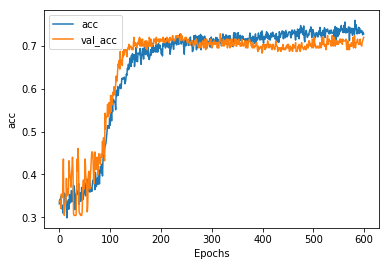

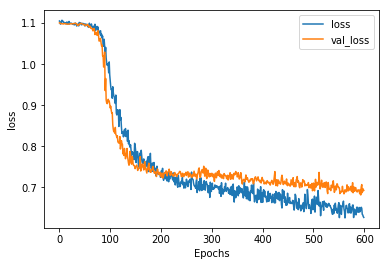

0.7283950536339371
0.7283950536339371 0.7324153803012989


In [0]:
plot_graphs(history, 'acc')
plot_graphs(history, 'loss')
print(max(history.history['val_acc']))
print(min(history.history['val_loss']))

In [0]:
# In[6] Save necessary files

Final_model.save(os.path.join(temppath,'my_model.hdf5'))
Final_model.save_weights(os.path.join(temppath,'my_model_weights.hdf5'))
with open(os.path.join(temppath,'model_architecture.json'), 'w') as f:
    f.write(Final_model.to_json())
# Saving some variables that might be used during testing
filename = os.path.join(temppath, 'LSTM_model_variables.sav')
with open(filename, 'wb') as handle:
    pickle.dump(classes, handle, protocol=pickle.HIGHEST_PROTOCOL)
    #pickle.dump(Final_portion, handle, protocol=pickle.HIGHEST_PROTOCOL)
    #pickle.dump(Final_learning_rate, handle, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(Final_batch_size, handle, protocol=pickle.HIGHEST_PROTOCOL)
    #pickle.dump(Final_lr_decay, handle, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(Final_layers, handle, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
# In[6] Evaluating

loss, acc = model.evaluate(X_test, y_test)
print()
print("Test accuracy = ", acc)

# Prediction
pred = model.predict(X_test)
#print(confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1)))
y_actu = pd.Series(y_test.argmax(axis=1), name='Actual')
y_pred = pd.Series(pred.argmax(axis=1), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)
print('Total time taken is {:.3f} min'.format((time.time()-beg)/60))

244/244 [==============================] - 1s 3ms/step

Test accuracy =  0.717213113776973
Predicted   0   1   2
Actual               
0          57  26   8
1          15  71   1
2          14   5  47
Total time taken is 63.203 min


## Tests

In [0]:
from IPython.display import clear_output

for i in range(10):
    clear_output()
    print("Hello World!")
sleep(2)
clear_output()

In [0]:
# df = pd.read_csv(os.path.join('.','Output','Data_train.csv')) #read data
# df = df.append(pd.read_csv(os.path.join('.','Output','Humans_train.csv'))) #read data
# df = df.append(pd.read_csv(os.path.join('.','Output','Humans_train_lite.csv')).replace('P1', 'P11'))
# df = df.append(pd.read_csv(os.path.join('.','Output','Humans_train_added.csv')))
df = pd.read_csv(os.path.join('.','Output','Activity_train.csv'))
df = df.fillna(0) #conver NaN values to zeros
# Getting consistant sequence of frames
fr = df.copy()['Frame']
seq_count = np.zeros(fr.shape, dtype=int)
for i in range(1, len(fr.index)):
    # assuming if there is > 20 frames gap, the scene is changed
    if np.abs(fr.values[i-1] - fr.values[i]) > 30:
        seq_count[i] = seq_count[i-1] + 1
    else:
        seq_count[i] = seq_count[i-1]
framesInSeq = np.bincount(seq_count)
maxSeq = framesInSeq.max()
print(maxSeq)

70


In [0]:
print(framesInSeq.mean())
print(np.median(framesInSeq))
print(np.bincount(framesInSeq).argmax())
print(sorted(framesInSeq))
# [1, 1, 3, 5, 14, 14, 32, 40, 42, 47, 64, 72, 83, 85, 90, 99, 108, 120, 120, 121, 126, 129, 130, 144, 148, 281, 297, 325, 385, 861]
# len([0]*X.shape[1]) 

17.00502512562814
15.0
13
[1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1